<center><h1><font color='#219ebc'>Starbucks Capstone Challenge</font></h1></center>
<center><h3><font color='#ffb703'>Udacity Data Scientist Nanodegree <br>Sorcha Nic Conmara</font></h3></center>

# Contents:
### 1 - [Project Definition](#section1)
### 2 - [Analysis](#section2)
### 3 - [Modelling Prep](#section3)
### 4 - [Modelling](#section4)
### 5 - [Model Evaluation](#section5)
### 6 - [Conclusion](#section6)

The entire notebook takes **~15mins** to fully run.

---
<a id='section1'><h1> 1. Project Definition </h1></a>

---

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

## Problem Statement

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* **id (string)** - offer id
* **offer_type (string)** - type of offer ie BOGO, discount, informational
* **difficulty (int)** - minimum required spend to complete an offer
* **reward (int)** - reward given for completing an offer
* **duration (int)** - time for offer to be open, in days
* **channels (list of strings)**
---
**profile.json**
* **age (int)** - age of the customer 
* **became_member_on (int)** - date when customer created an app account
* **gender (str)** - gender of the customer (note some entries contain 'O' for other rather than M or F)
* **id (str)** - customer id
* **income (float)** - customer's income
---
**transcript.json**
* **event (str)** - record description (ie transaction, offer received, offer viewed, etc.)
* **person (str)** - customer id
* **time (int)** - time in hours since start of test. The data begins at time t=0
* **value - (dict of strings)** - either an offer id or transaction amount depending on the record

## Method

For this capstone challenge, I'm particularly interested in investigating the customer demographics, the offers portfolio and the transcripts data to answer a few questions such as:

**Q1.** What was the age distribution of Starbucks customers in the dataset?

**Q2.** What was the distribution of customer tenure in the dataset?

**Q3.** What year saw the most new memberships and what month of the year saw the most memberships?

**Q4.** What was the gender distribution of customers in the Starbucks dataset? 

**Q5.** What was the income distribution by gender?

**Q6.** What was the income distribution by age group?

**Q7.** What was the distribution of events in the transcript dataset?

**Q8.** Was there a pattern in the release of offers?

**Q9.** What was the distribution of transaction amounts?

**Q10.** What were the most common offer types by channel?

**Q11.** What were the distributions for duration, reward and difficulty of offers?

**Q12.** What was the mean spend and number of transactions by gender?

**Q13.** What offer types were most popular across age groups and income groups?

**Q14.** What offer types were most popular across genders and membership years?


Following on from this, I train a supervised propensity model to predict **the propensity of a customer completing an offer WITHOUT any influence from the app versus a customer completing an offer as a direct result of viewing an offer from the app (influenced).** Ideally, a model such as the one in this notebook would be used to help to identify which customers would be most responsive to receiving an offer and would be likely to view it and complete it. It would also help to identify those customers likely to complete the offer regardless and therefore wouldn't necessarily need to receive the offer.

A number of models and parameters were trialled using GridSearchCV with **LightGBM** as the final best model, producing an accuracy score of 0.74.

**Model Target:**
- 1 = Customer completed an offer after viewing it in the app
- 0 = Customer completed an offer without viewing it in the app beforehand

This notebook will cover the following:

- Data Exploration
- Data Wrangling/Pre-processing/Cleaning
- Data Visualisation
- Feature Engineering
- Data Encoding
- Data Scaling
- Development of a Supervised Machine Learning Model
- Model Evaluation
- Conclusion

## Metrics

The metric chosen to evaluate the supervised model was **accuracy**. Accuracy is the proportion of true results among the total number of cases examined. This metric was chosen because the model was a **classification model** and accuracy allowed me to assess how well the model was at correctly predicting the target variable.

***Accuracy = (TP+TN)/(TP+FP+FN+TN)***

## Import Libraries & Raw Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import json
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.pipeline import Pipeline as sk_pipeline
from sklearn.pipeline import FeatureUnion

RANDOM_STATE = 42
pd.options.display.html.table_schema=True
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = None

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## User Defined Functions

In [3]:
def print_line(title='Default Title'):
    ''' Function to format titles nicely '''
    print(50 * '*' + '\n\t\t' + title + '\n' + 50 * '*')
    
    return


def get_offer_id(x):
    '''Get offer_id from value column either by indexing on 'offer_id' or 'offer id' '''
    try :
        return x['offer id']
    except:
        return x['offer_id']
    
    
def plot_conf_mat(y_test, y_pred):
    '''Plots a confusion matrix using Seaborn's heatmap()'''
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
    annot=True, # Annotate the boxes
    fmt='g',
    cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    

---
<a id='section2'><h1> 2. Analysis </h1></a>

---

## Data Cleaning/Pre-processing & Data Visualisations

## 1. Profile Data

In [4]:
print_line('Shape')
print(profile.shape)
print_line('Dtypes')
print(profile.dtypes)
print_line('Duplicate IDs')
print(profile.id.duplicated().any())
print_line('% of Nulls')
print(profile.isnull().mean())
print_line('Mean vs Median Income')
print('Mean Income:\t', profile.income.mean())
print('Median Income:\t', profile.income.median())
profile.head()

**************************************************
		Shape
**************************************************
(17000, 5)
**************************************************
		Dtypes
**************************************************
gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object
**************************************************
		Duplicate IDs
**************************************************
False
**************************************************
		% of Nulls
**************************************************
gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64
**************************************************
		Mean vs Median Income
**************************************************
Mean Income:	 65404.9915682968
Median Income:	 64000.0


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
# convert int to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# calculate customer tenure
# latest membership date is 26th of July 2018 so calculate customer tenure as of end of July 2018
as_of_date = datetime(2018,7,31)
profile['tenure_in_months'] = profile['became_member_on'].apply(lambda x: (as_of_date.year - x.year) * 12 \
                                                                + (as_of_date.month - x.month)).astype(int)
# extract year from membership date
profile['membership_year'] = pd.DatetimeIndex(profile['became_member_on']).year

# fill NAs in gender with U(unknown) 
# impute income with median and create indicator of missing income
profile['gender'].fillna('U', inplace=True)
profile['missing_income'] = profile['income'].isnull().astype(int)
profile['income'].fillna(profile['income'].median(), inplace=True)
profile['income'] = profile['income'].astype(int)

# bin age groups
age_bins = [17,24,34,44,54,64,74,84,101,118]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-101', 'Default Age']
profile['age_group'] = pd.cut(profile['age'], bins=age_bins, labels=age_labels)

# bin incomes
income_bins = [29999,60000,90000,120000]
income_labels = ['below average', 'average', 'above average']
profile['income_group'] = pd.cut(profile['income'], bins=income_bins, labels=income_labels)

In [6]:
print_line('Value Counts for Gender')
print(profile.gender.value_counts())
print_line('Unique Ages')
print(sorted(profile.age.unique()))
print_line('Age Group Distribution')
print(profile.age_group.value_counts().sort_index())
print_line('Income Group Distribution')
print(profile.income_group.value_counts().sort_index())
print_line('Summary Stats (Numbers)')
print(profile.describe())
print_line('Summary Stats (Objects)')
print(profile.describe(include = 'object'))
profile.head()

**************************************************
		Value Counts for Gender
**************************************************
M    8484
F    6129
U    2175
O     212
Name: gender, dtype: int64
**************************************************
		Unique Ages
**************************************************
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 118]
**************************************************
		Age Group Distribution
**************************************************
18-24           876
25-34          1380
35-44          1869
45-54          3013
55-64          3421
65-74          2457
75-84          1231
85-101          578
Default Age    2175
Name: age_group, dtype: int64
********

,gender,age,id,became_member_on,income,tenure_in_months,membership_year,missing_income,age_group,income_group
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000,17,2017,1,Default Age,average
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000,12,2017,0,55-64,above average
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000,0,2018,1,Default Age,average
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000,14,2017,0,75-84,above average
4,U,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000,11,2017,1,Default Age,average


### Q1. What was the age distribution of Starbucks customers in the dataset?
Distribution of Customer Age Groups (Bucketed)

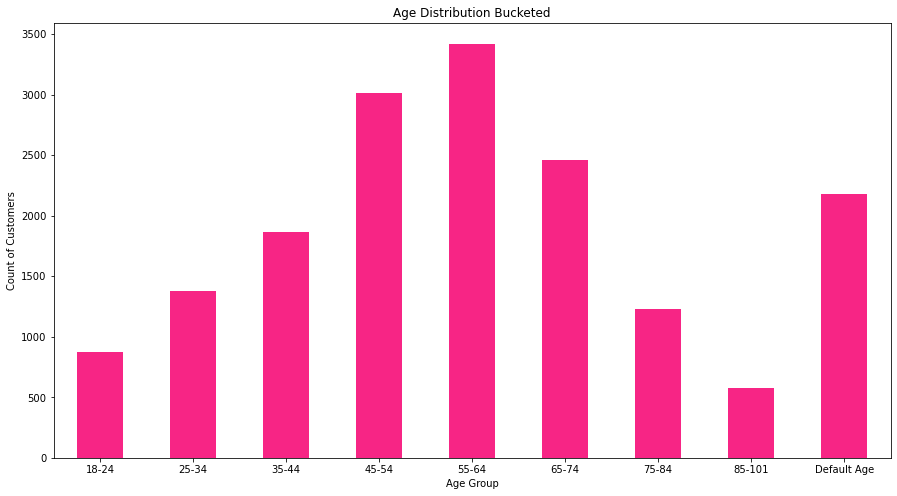

In [7]:
fig, ax = plt.subplots(figsize=(15,8))

profile.age_group.value_counts().sort_index().plot(kind='bar', ax=ax, color=["#f72585"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Age Distribution Bucketed')
ax.set_ylabel('Count of Customers')
ax.set_xlabel('Age Group');


The majority of Starbucks customers in the dataset were in the 55-64 year age group. Overall, customers aged 45-75 accounted for ~52% of the dataset.

### Q2. What was the distribution of customer tenure in the dataset?

Distribution of Customer Tenure

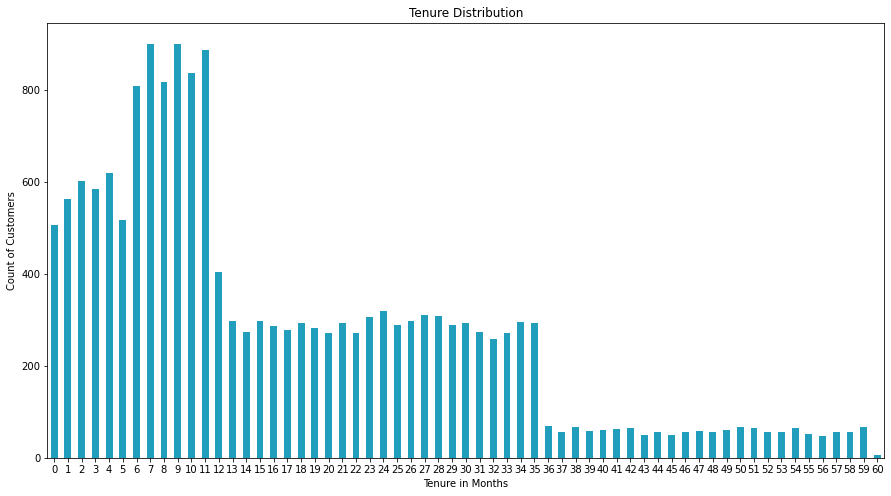

In [8]:
fig, ax = plt.subplots(figsize=(15,8))

profile.tenure_in_months.value_counts().sort_index().plot(kind='bar', ax=ax, color=['#219ebc'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Tenure Distribution')
ax.set_ylabel('Count of Customers')
ax.set_xlabel('Tenure in Months');


The majority of customers had a tenure of between 6-11 months, so a lot of these customers were relatively new to the Starbucks membership programme. 

### Q3. What year saw the most new memberships and what month of the year saw the most memberships?

Distribution of Memberships by Year and by Months of the Year

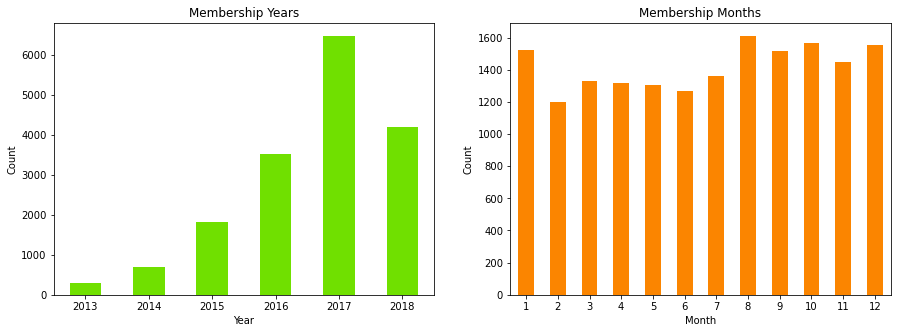

In [9]:
membership_years = pd.DatetimeIndex(profile['became_member_on']).year
membership_months = pd.DatetimeIndex(profile['became_member_on']).month

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

membership_years.value_counts().sort_index().plot(kind='bar', ax=ax1, color=['#70e000'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Membership Years')
ax1.set_ylabel('Count')
ax1.set_xlabel('Year');

membership_months.value_counts().sort_index().plot(kind='bar', ax=ax2, color=['#fb8500'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Membership Months')
ax2.set_ylabel('Count')
ax2.set_xlabel('Month');

2017 saw a relatively large spike in memberships compared to 2016 (up ~50%). There was possibly a campaign to drive memberships that year. Overall, memberships are steady across each month over the years. However, August is the most popular month for new memberships overall.

### Q4. What was the gender distribution of customers in the Starbucks dataset? 

Gender Distribution Across Customer Profiles

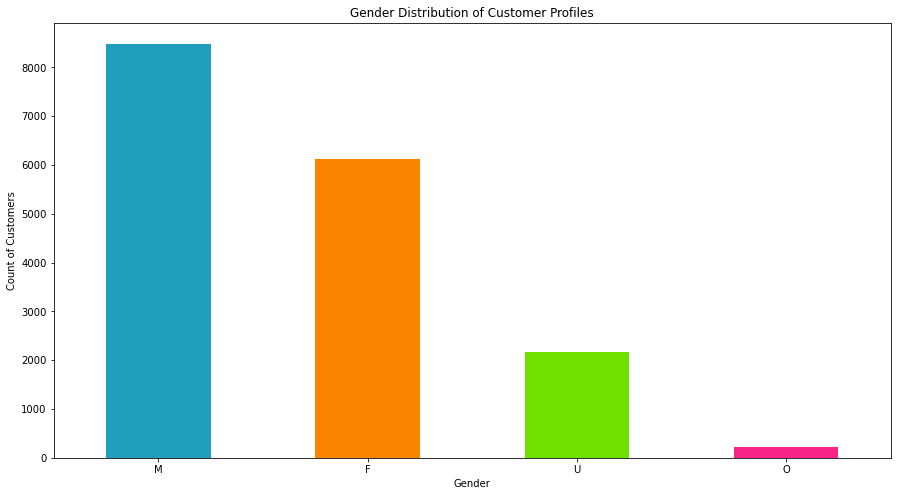

In [10]:
fig, ax = plt.subplots(figsize=(15,8))

profile.gender.value_counts().plot(kind='bar', ax=ax, color=["#219ebc","#fb8500","#70e000","#f72585"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Gender Distribution of Customer Profiles')
ax.set_ylabel('Count of Customers')
ax.set_xlabel('Gender');


~50% of customers are male, ~36% are female, ~1.25% are 'other' and ~12.75% are unknown. 

### Q5. What was the income distribution by gender?

Income Distribution by Gender

C:\Users\SNicConmara\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


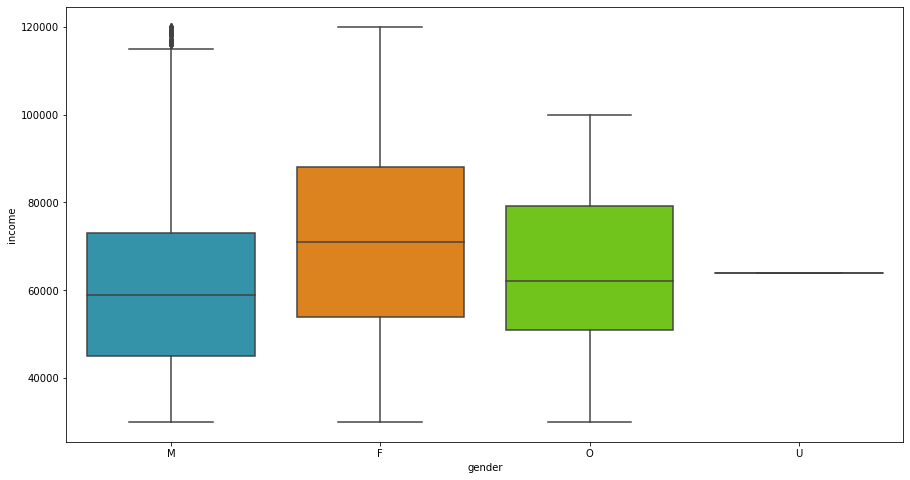

In [11]:
fig, ax = plt.subplots(figsize=(15,8))

colors = {"M": "#219ebc", "F": "#fb8500", "O":"#70e000", "U":"#f72585"}
sns.boxplot('gender', 'income', data=profile, ax=ax, order=['M', 'F', 'O', 'U'], palette=colors);

In [12]:
profile.groupby('gender').describe()['income']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0
U,2175.0,64000.000000,0.000000,64000.0,64000.0,64000.0,64000.0,64000.0


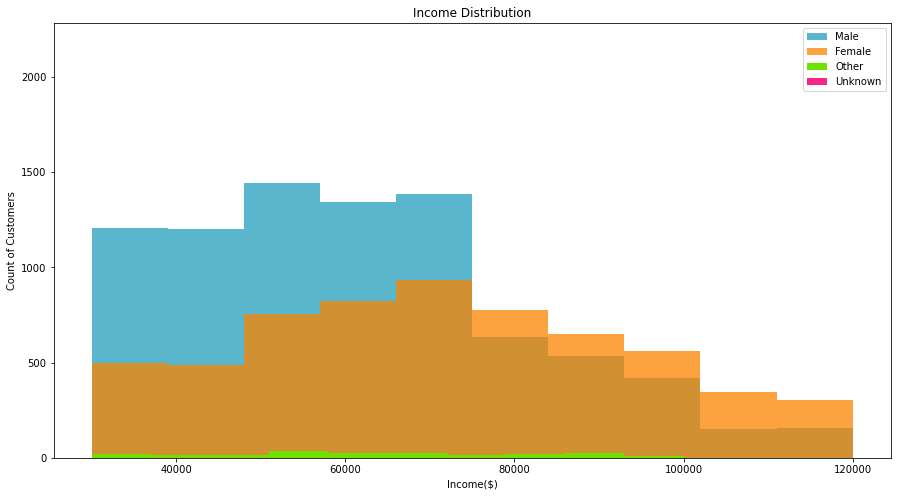

In [13]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hist(profile.query("gender == 'M'")['income'], alpha=0.75, color='#219ebc', label='Male')
ax.hist(profile.query("gender == 'F'")['income'], alpha=0.75, color='#fb8500', label='Female')
ax.hist(profile.query("gender == 'O'")['income'], alpha=1, color='#70e000', label='Other')
ax.hist(profile.query("gender == 'U'")['income'], alpha=1, color='#f72585', label='Unknown')
ax.set_xlabel('Income($)')
ax.set_ylabel('Count of Customers')
ax.set_title('Income Distribution')
ax.legend();

The income distribution by gender is quite interesting. We can see from the plots above that the average income of Starbucks customers is higher for females than for males. The distribution of female incomes is also wider and less-skewed than the male income distribution. Both male and female incomes range from 30k to 120k.

### Q6. What was the income distribution by age group?

Income Distribution by Age Group

C:\Users\SNicConmara\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


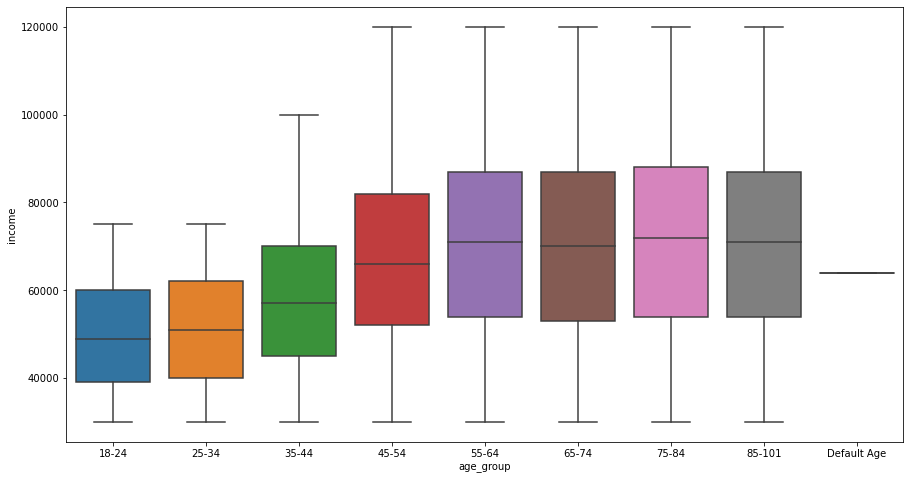

In [14]:
fig, ax = plt.subplots(figsize=(15,8))

sns.boxplot('age_group', 'income', data=profile, ax=ax);

Unsurprisingly, customers aged 18-44 have lower incomes on average than those ages 44+. This is likely due to years in a career/industry and potential career progression with age.

## 2. Transcript Data

In [15]:
# rename person to customer_id
transcript.rename(columns={'person':'customer_id', 'time':'time_hours'}, inplace=True)

# check if there are any customer IDs which do not appear in profile df, drop if they exist
transcript['customer_id_in_profile'] = transcript['customer_id'].isin(profile['id']).astype(int)
transcript = transcript[transcript.customer_id_in_profile == 1]

# convert time from hours to days for exploratory analysis purposes
transcript['days_since_test_start'] = (transcript['time_hours']/24).astype(int)

# extract offer id or transaction amount from value column
transcript['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
    .value.apply(lambda x: get_offer_id(x))
transcript['transaction_amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])

# drop unused columns
transcript.drop(['customer_id_in_profile', 'value'], axis=1, inplace=True)

In [16]:
#397 completely identical rows - remove these from transcript dataset
len(transcript[transcript.duplicated()])

397

In [17]:
print_line('Old shape')
print(transcript.shape)

print_line('Duplicate Rows Removed')
print(len(transcript[transcript.duplicated()]))
transcript.drop_duplicates(inplace=True)

print_line('New shape')
print(transcript.shape)

**************************************************
		Old shape
**************************************************
(306534, 6)
**************************************************
		Duplicate Rows Removed
**************************************************
397
**************************************************
		New shape
**************************************************
(306137, 6)


In [18]:
print_line('Shape')
print(transcript.shape)
print_line('Dtypes')
print(transcript.dtypes)
print_line('# Unique customer IDs')
print(transcript.customer_id.unique().shape)
print_line('# Profiles')
print(profile.id.unique().shape)
print_line('Types of Events')
print(transcript.event.value_counts())
print_line('Days Since Test Start')
print(transcript.days_since_test_start.value_counts().sort_index())
print_line('% of Nulls')
print(transcript.isnull().mean())
transcript.head()

**************************************************
		Shape
**************************************************
(306137, 6)
**************************************************
		Dtypes
**************************************************
customer_id               object
event                     object
time_hours                 int64
days_since_test_start      int32
offer_id                  object
transaction_amount       float64
dtype: object
**************************************************
		# Unique customer IDs
**************************************************
(17000,)
**************************************************
		# Profiles
**************************************************
(17000,)
**************************************************
		Types of Events
**************************************************
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64
**********************************************

,customer_id,event,time_hours,days_since_test_start,offer_id,transaction_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [19]:
received_mean = transcript.query("event == 'offer received'")['days_since_test_start'].mean()
received_cnt = transcript.query("event == 'offer received'")['days_since_test_start'].count()

completed_mean = transcript.query("event == 'offer completed'")['days_since_test_start'].mean()
completed_cnt = transcript.query("event == 'offer completed'")['days_since_test_start'].count()

viewed_mean = transcript.query("event == 'offer viewed'")['days_since_test_start'].mean()
viewed_cnt = transcript.query("event == 'offer viewed'")['days_since_test_start'].count()

transactions_mean = transcript.query("event == 'transaction'")['days_since_test_start'].mean()
transactions_cnt = transcript.query("event == 'transaction'")['days_since_test_start'].count()

print_line('Mean Days')
print('Offer received:\t', received_mean)
print('Offer viewed:\t', viewed_mean)
print('Offer completed:', completed_mean)
print('Transactions:\t', transactions_mean)

print_line('Counts')
print('Offer received:\t', received_cnt)
print('Offer viewed:\t', viewed_cnt)
print('Offer completed:', completed_cnt)
print('Transactions:\t', transactions_cnt)

**************************************************
		Mean Days
**************************************************
Offer received:	 13.85747997430418
Offer viewed:	 14.462468601126028
Offer completed: 16.2958230365861
Transactions:	 15.52511280792786
**************************************************
		Counts
**************************************************
Offer received:	 76277
Offer viewed:	 57725
Offer completed: 33182
Transactions:	 138953


### Q7. What was the distribution of events in the transcript dataset?
Distribution of Events

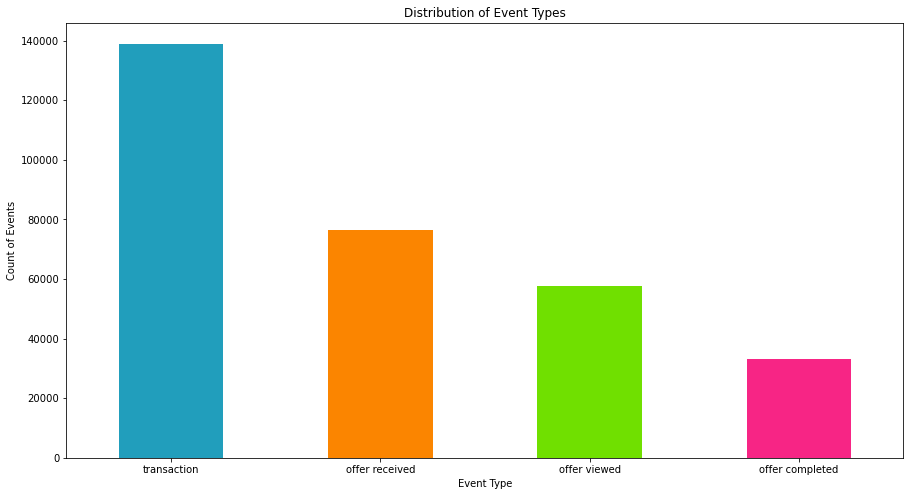

In [20]:
fig, ax = plt.subplots(figsize=(15,8))

transcript.event.value_counts().plot(kind='bar', ax=ax, color=["#219ebc","#fb8500","#70e000","#f72585"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Distribution of Event Types')
ax.set_ylabel('Count of Events')
ax.set_xlabel('Event Type');

The most common events in the transcript data were transactions, followed by offers received, offers viewed and offers compelted. This makes sense as we would not expect all customers who receive an offer to view it, nor would we expect all customers who view an offer to complete it. Ideally, a model such as the one in this notebook would be used to help to identify which customers would be most responsive to receiving an offer and would be likely to view it and complete it.

### Q8. Was there a pattern in the release of offers?
Distribution of Days Since Test Start

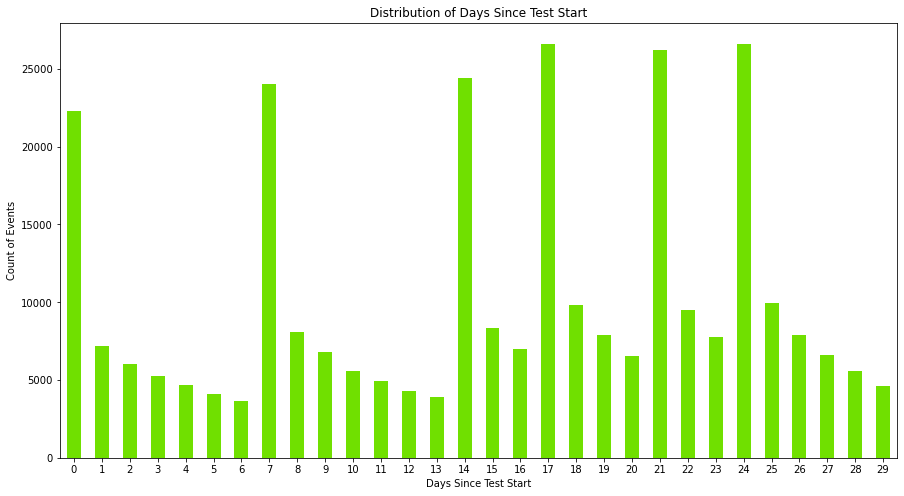

In [21]:
fig, ax = plt.subplots(figsize=(15,8))

transcript.days_since_test_start.value_counts().sort_index().plot(kind='bar', ax=ax, color=["#70e000"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Distribution of Days Since Test Start')
ax.set_ylabel('Count of Events')
ax.set_xlabel('Days Since Test Start');

When we look at the distribution of time (converted to days) since test start, we can see clear spikes on days 0,7,14,21, etc. which suggests that the tests perhaps commence weekly or that there is clear scheduling behind receiving offers and completing offers.

### Q9. What was the distribution of transaction amounts?
Distributions of Transaction Amounts

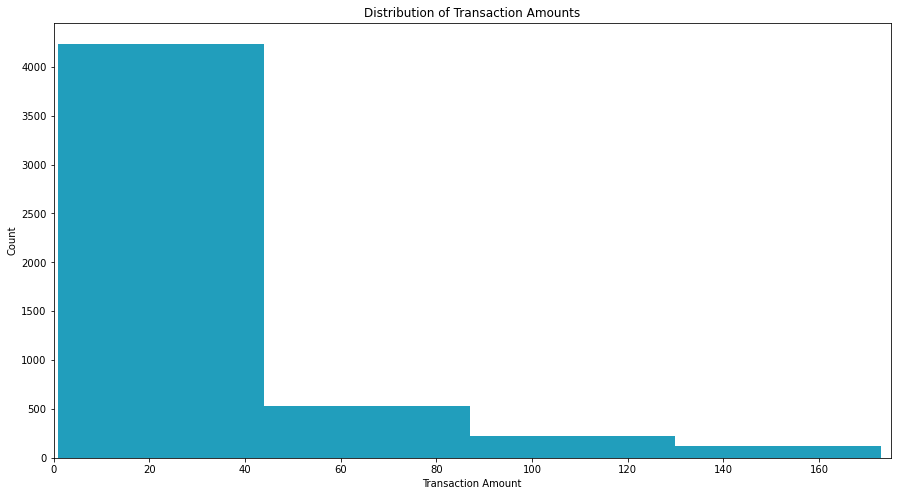

In [22]:
fig, ax = plt.subplots(figsize=(15,8))

transcript.transaction_amount.value_counts().plot(kind='hist', ax=ax, color=["#219ebc"])
ax.set_title('Distribution of Transaction Amounts')
ax.set_xlim(0,175)
ax.set_ylabel('Count')
ax.set_xlabel('Transaction Amount');

count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: transaction_amount, dtype: float64


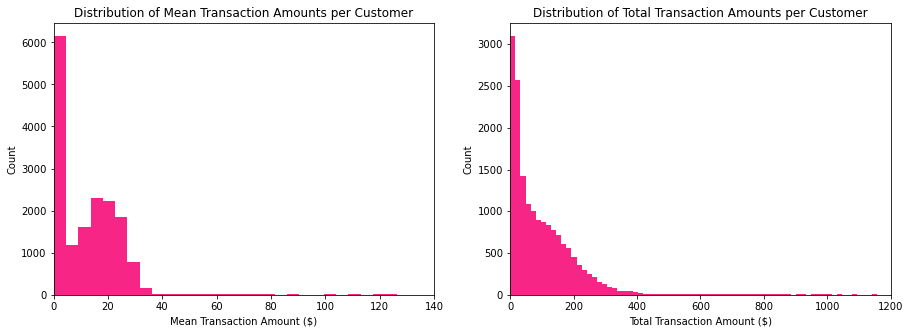

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

transcript.groupby('customer_id')['transaction_amount'].mean().plot(kind='hist', bins=100, ax=ax1, color=["#f72585"])
ax1.set_title('Distribution of Mean Transaction Amounts per Customer')
ax1.set_xlim(0,140)
ax1.set_ylabel('Count')
ax1.set_xlabel('Mean Transaction Amount ($)')

transcript.groupby('customer_id')['transaction_amount'].sum().plot(kind='hist', bins=100, ax=ax2, color=["#f72585"])
ax2.set_title('Distribution of Total Transaction Amounts per Customer')
ax2.set_xlim(0,1200)
ax2.set_ylabel('Count')
ax2.set_xlabel('Total Transaction Amount ($)');

print(transcript.groupby('customer_id')['transaction_amount'].mean().describe())

count    17000.000000
mean         8.173706
std          5.116250
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: transaction_amount, dtype: float64

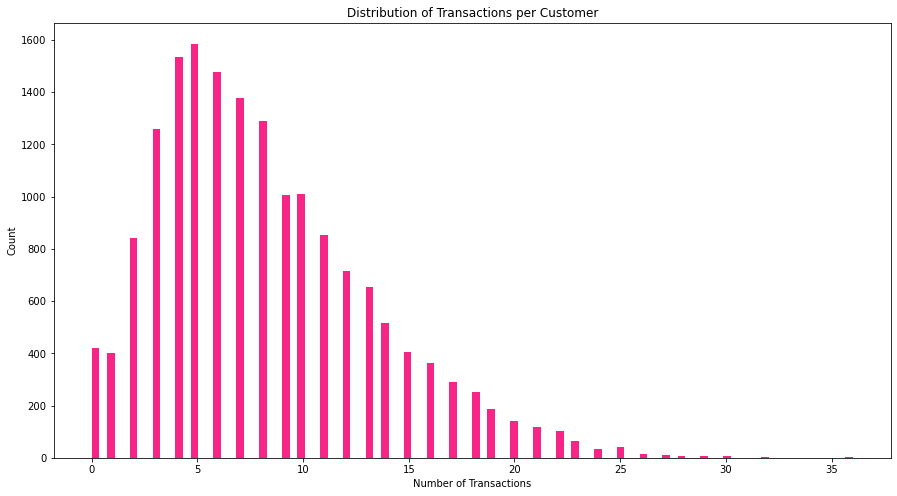

In [24]:
fig, ax = plt.subplots(figsize=(15,8))

transcript.groupby('customer_id')['transaction_amount'].count().plot(kind='hist', bins=100, ax=ax, color=["#f72585"])
ax.set_title('Distribution of Transactions per Customer')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Transactions');

transcript.groupby('customer_id')['transaction_amount'].count().describe()

As expected, the distribution of transaction amounts is very skewed. This makes sense as Starbucks is a coffee shop and therefore we would not expect many large transactions from customers. From examining the distribution of mean transaction amounts per customer and the distribution of total transaction amounts per customer, we can also see that Starbucks transactions are primarily comprised of multiple smaller transactions. This likely lends to their membership offers.

## 3. Portfolio Data

In [25]:
print_line('Shape')
print(portfolio.shape)
print_line('Dtypes')
print(portfolio.dtypes)
print_line('Duplicate IDs')
print(portfolio.id.duplicated().any())
print_line('% of Nulls')
print(portfolio.isnull().mean())
print_line('Types of Offers')
print(portfolio.offer_type.value_counts())
print(portfolio.offer_type.describe())
print_line('Describe Difficulty & Duration')
print(portfolio[['difficulty', 'duration']].describe())
print_line('Channels')
print(portfolio.channels.value_counts())
portfolio.head(10)

**************************************************
		Shape
**************************************************
(10, 6)
**************************************************
		Dtypes
**************************************************
reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object
**************************************************
		Duplicate IDs
**************************************************
False
**************************************************
		% of Nulls
**************************************************
reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64
**************************************************
		Types of Offers
**************************************************
discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64
count           10
unique           3
top       discount
freq

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [26]:
# one hot encode offers, save to separate df and concat with portfolio df
offer_type_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio,offer_type_dummies], axis = 1)

mlb = MultiLabelBinarizer()

# one hot encode channels, save to separate df and concat with portfolio df
ohe_channels = mlb.fit_transform(portfolio['channels'])
df_channels = pd.DataFrame(data=ohe_channels, columns=mlb.classes_)
portfolio = pd.concat([portfolio,df_channels], axis=1)
# drop original columns
portfolio.drop(['channels'], axis=1, inplace=True)

# add prefix to ohe columns
portfolio.rename(columns = {'email':'channel_email', 'mobile':'channel_mobile', \
                            'social':'channel_social', 'web':'channel_web'}, inplace=True)

### Q10. What were the most common offer types by channel?
Count of Offer Types by Channels

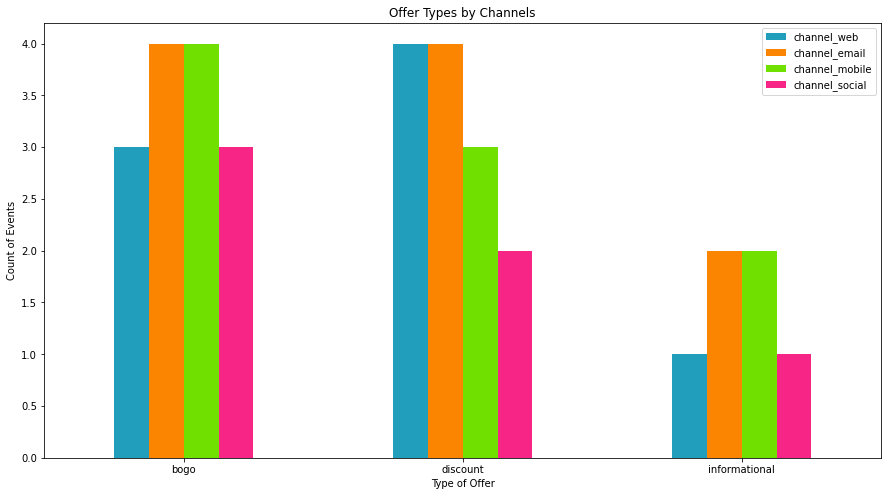

In [27]:
fig, ax = plt.subplots(figsize=(15,8))

portfolio.groupby('offer_type').sum()[['channel_web', 'channel_email', 'channel_mobile', 'channel_social']]\
.plot(kind='bar', ax=ax, color=["#219ebc","#fb8500","#70e000","#f72585"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Offer Types by Channels')
ax.set_ylabel('Count of Events')
ax.set_xlabel('Type of Offer');

- The most popular channels for bogo offers were email and mobile.
- The most popular channels for discount offers were email and web.
- The most popular channels for informational offers were email and mobile.

In [28]:
#drop offer type now that it is one hot encoded
portfolio.drop(['offer_type'], axis=1, inplace=True)

In [29]:
print_line('Shape')
print(portfolio.shape)
print_line('Dtypes')
print(portfolio.dtypes)
portfolio.head()

**************************************************
		Shape
**************************************************
(10, 11)
**************************************************
		Dtypes
**************************************************
reward                  int64
difficulty              int64
duration                int64
id                     object
offer_bogo              uint8
offer_discount          uint8
offer_informational     uint8
channel_email           int32
channel_mobile          int32
channel_social          int32
channel_web             int32
dtype: object


,reward,difficulty,duration,id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


### Q11. What were the distributions for duration, reward and difficulty of offers?
 
Distributions of Duration, Reward and Difficulty by Count of Offers

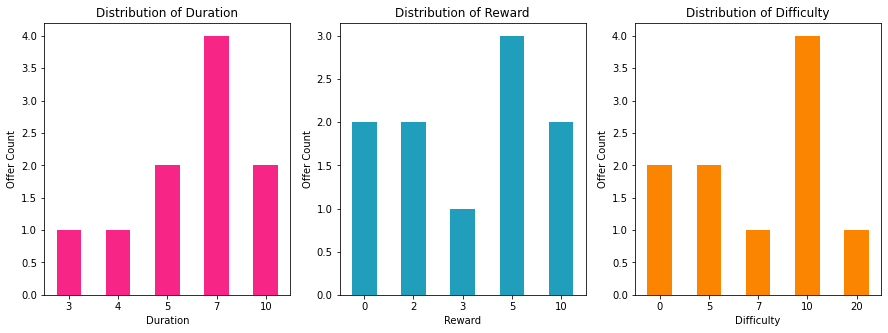

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

portfolio.duration.value_counts().sort_index().plot(kind='bar', ax=ax1, color=['#f72585'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Distribution of Duration')
ax1.set_ylabel('Offer Count')
ax1.set_xlabel('Duration');

portfolio.reward.value_counts().sort_index().plot(kind='bar', ax=ax2, color=['#219ebc'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Distribution of Reward')
ax2.set_ylabel('Offer Count')
ax2.set_xlabel('Reward');

portfolio.difficulty.value_counts().sort_index().plot(kind='bar', ax=ax3, color=['#fb8500'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.set_title('Distribution of Difficulty')
ax3.set_ylabel('Offer Count')
ax3.set_xlabel('Difficulty');

The most common duration of offers was 7 days (1 week) which coincides with the spike in 'days since test start' we saw earlier. Most rewards for offers were 5, 0 or 2 dollars and the most common difficulty was $10. This most common difficulty was to be expected as it allows Starbucks to make these membership offers profitable and worth the company's while.

In [31]:
print_line('Duration')
print('median\t', portfolio.duration.median())
print(portfolio.duration.describe())

**************************************************
		Duration
**************************************************
median	 7.0
count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64


In [32]:
print_line('Reward')
print('median\t', portfolio.reward.median())
print(portfolio.reward.describe())

**************************************************
		Reward
**************************************************
median	 4.0
count    10.000000
mean      4.200000
std       3.583915
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: reward, dtype: float64


In [33]:
print_line('Difficulty')
print('median\t', portfolio.difficulty.median())
print(portfolio.difficulty.describe())

**************************************************
		Difficulty
**************************************************
median	 8.5
count    10.000000
mean      7.700000
std       5.831905
min       0.000000
25%       5.000000
50%       8.500000
75%      10.000000
max      20.000000
Name: difficulty, dtype: float64


# Summary of Data Pre-processing

## 1. Profile Data:
- ```became_member_on``` converted to date
- ```membership_year``` attribute created
- customer ```tenure_in_months``` calculated as of end of July 2018
- Nulls in ```gender``` filled with 'U' for 'Unknown'
- Nulls in ```income``` imputed with median income value and ```income``` datatype converted to int.
- ```missing_income``` column created which indicates if ```income``` was Null
- ```age_group``` column created which bins the ages

## 2. Transcript Data:
- ```offer id``` and ```transaction_amount``` columns created from extracting data from ```value``` column
- ```time``` converted from hours to days to create column ```days_since_test_start```
- ```person``` renamed to ```customer_id```
- ```time``` renamed to ```time_hours```

## 3. Portfolio Data:
- ```offer_type``` was one hot encoded using pd.get_dummies()
- ```channels``` was one hot encoded using a MultiLabelBinarizer
- Original ```channels``` and ```offer_type``` columns dropped

# Summary of Exploratory Data Analysis

## 1. Profile Data:
- There are 17,000 customers in the dataset.
- 2,175 customers are missing income, age and gender from the dataset.

- ~50% of customers are male, ~36% are female, ~1.25% are other and ~12.75% are unknown.

- Ages range from 18-101 with a default age of 118 poulated for 2,175 customers missing an age in the dataset.

- The most common age groups are 55-64(3,421), 45-54(3,013) and 65-74 (2,457).

- Mean age is 62.

- Mean income is ~65k, incomes range from ~30k to ~120k.

- Mean income is higher for females than males and others.
 
- Customer tenure in months range from 0 months to 60 months (5years).

- 2017 was the busiest year in terms of new memberships, and overall, memberships were steady month by month over the years.

## 2. Transcript Data:
- There are 306,534 transcript records.

- There are 4 distinct types of events - offer received, offer viewed, offer completed and transaction.

- The days since test start range from 0 to 29 days.

- The following were the mean days since test start for each event type: 
   
   Offer received:	 13.86 days
   
   Offer viewed:	 14.46 days
   
   Offer completed: 16.35 days
   
   Transactions:	 15.53 days


- Transactions were the most common event types, followed by offer received, offer viewed and offer completed.

- On average, customers completed 8 transactions and have a mean transaction amount of ~$13

- When looking at the distribution of days since test start, we can see clear spikes on days 0,7,14,21 which suggests that tests commence weekly. 

- No missing values.


## 3. Portfolio Data:
- 10 unique offers in the portfolio of offers.

- Offers can be bogo (buy one get one free), discount or  informational  offers.

- Offers can come from web, email mobile or social channels.

- The most popular channels for bogo offers were email and mobile.
- The most popular channels for discount offers were email and web.
- The most popular channels for informational offers were email and mobile.



---
<a id='section3'><h1> 3. Modelling Prep </h1></a>

---

### Merge Datasets

Merge all 3 datasets and produce one final, master cleaned dataset for modelling.

In [34]:
# merge transcript and profile dataframes
transcript_profile = pd.merge(transcript, profile, left_on=['customer_id'], right_on = ['id'], how ='left')

#drop duplicate customer id column
transcript_profile.drop('id', axis=1, inplace=True)

#merge transcript, profile and portfolio dataframes
final_data = pd.merge(transcript_profile, portfolio, left_on=['offer_id'], right_on = ['id'], how ='left')\
                .drop('id', axis=1)

There were 3 more questions from my initial EDA I wanted to answer before dropping the transaction data for the final modelling dataset and they were as follows:

### Q12. What was the mean spend and number of transactions by gender?
Number of Transactions and Transaction Amounts by Gender

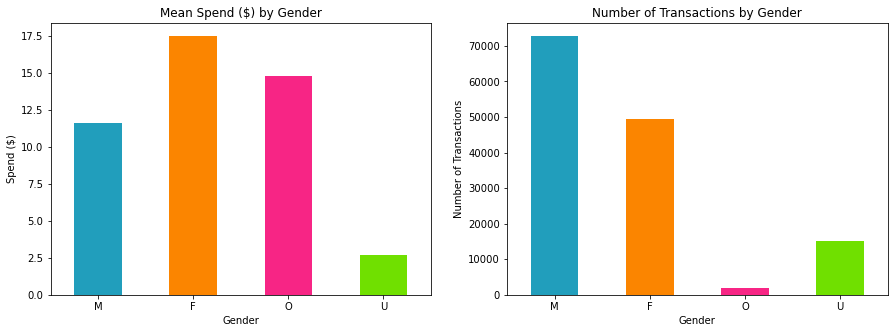

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

final_data.groupby('gender')['transaction_amount'].mean()[['M', 'F', 'O', 'U']]\
                            .plot(kind='bar', ax=ax1, color=["#219ebc","#fb8500","#f72585","#70e000"]);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_xlabel("Gender")
ax1.set_ylabel("Spend ($)")
ax1.set_title("Mean Spend ($) by Gender")

final_data.groupby('gender')['transaction_amount'].count()[['M', 'F', 'O', 'U']]\
                            .plot(kind='bar', ax=ax2, color=["#219ebc","#fb8500","#f72585","#70e000"]);
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax2.set_xlabel("Gender")
ax2.set_ylabel("Number of Transactions")
ax2.set_title("Number of Transactions by Gender");

On average, females spent the most even though they were only the second largest gender group in the customer dataset. The mean spend for 'others' was quite high as well but this is likely very skewed as the proportion of 'others' in the dataset is the smallest of the four gender categories defined.

### Q13. What offer types were most popular across age groups and income groups?
Offer Types across ages and Income

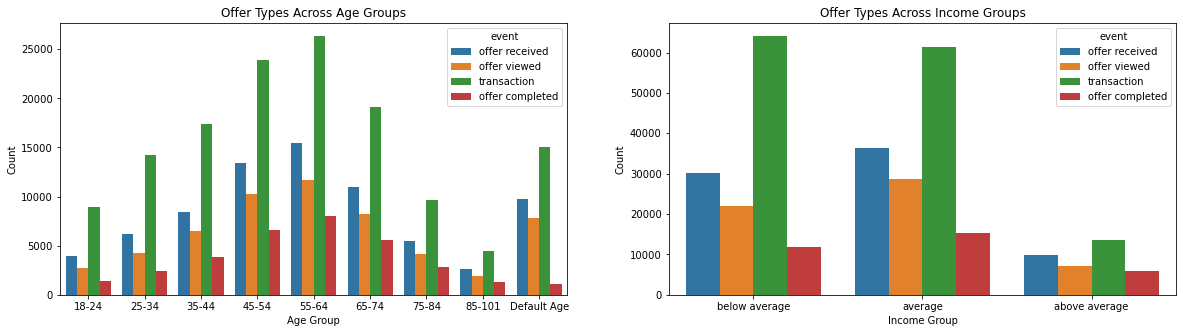

In [36]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
x = sns.countplot(data = final_data, x = 'age_group', hue = 'event')
plt.title('Offer Types Across Age Groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)

plt.subplot(1,2,2)
x = sns.countplot(data = final_data, x = 'income_group', hue = 'event')
plt.title('Offer Types Across Income Groups')
plt.ylabel('Count')
plt.xlabel('Income Group')
plt.xticks(rotation = 0);

As to be expected because of the distribution of ages across the customer dataset, those aged 55-64 completed the most offers and also had the most transactions. The breakdown of events was quite similar across age groups which isn't the most helpful is identifying key traits of a certain age demographic.

Interestingly, below average and average income customers had nearly the same amount of transactions compared to those with above average income. Customers with average income completed the most offers, followed by those with below average income and those with above average income.

### Q14. What offer types were most popular across genders and membership years?
Offer Types across Gender and Membership Year

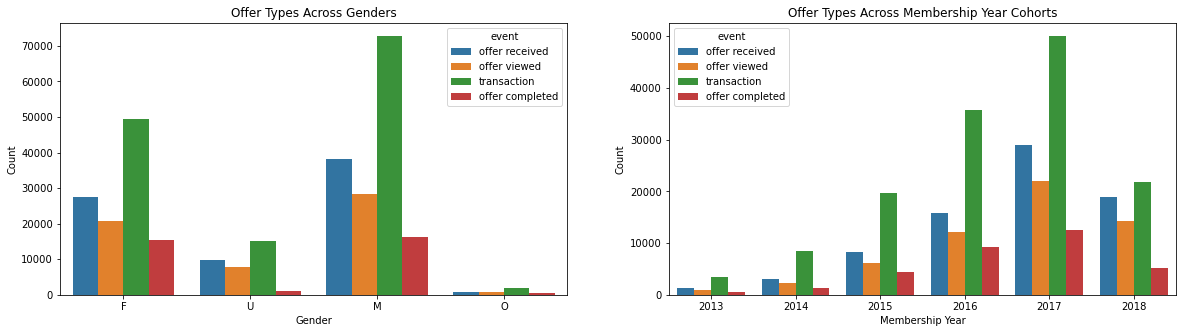

In [37]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
x = sns.countplot(data = final_data, x = 'gender', hue = 'event')
plt.title('Offer Types Across Genders')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation = 0)

plt.subplot(1,2,2)
x = sns.countplot(data = final_data, x = 'membership_year', hue = 'event')
plt.title('Offer Types Across Membership Year Cohorts')
plt.ylabel('Count')
plt.xlabel('Membership Year')
plt.xticks(rotation = 0);

Males completed far more transactions than offers compared to females. Also, those missing a gender in the dataset ('Unknown' gender) completed very few offers. Perhaps offers are tailored towards gender and customers missing this datapoint would received generic offers rather than tailored ones. Customers who became members in 2016 and 2017 completed the most offers and transactions. The number of offers completed was steadily increasing frmo 2013 to 2017 before it dropped in 2018. The strategy for offers/ difficulty possibly changed between 2017 and 2018.

In [38]:
#Drop any rows which relate to transactions
# as we are only interested in offers for this exercise
final_data = final_data[final_data.event != 'transaction']
final_data.reset_index(inplace=True, drop=True)

### Label Encoding

In [39]:
#Label encode features such as customer id, offer id, gender, etc
le = LabelEncoder()

cols_to_encode = ['customer_id', 'offer_id', 'gender', 'membership_year', 'age_group', 'income_group']
cols_to_drop = ['days_since_test_start', 'age', 'became_member_on', 'income', 'transaction_amount']

for col in cols_to_encode:
    le.fit(final_data[col])
    final_data[col] = le.fit_transform(final_data[col].astype(str))
    
# drop columns no longer necessary
final_data.drop(cols_to_drop, axis=1, inplace=True)

# add _hours to duration column title to match time_hours
final_data.rename(columns={'duration':'duration_hours'}, inplace=True)

### Target Creation

For this exercise, we are interested in **predicting whether a customer is likely to be influenced to complete an offer.** i.e. if they complete an offer, was it completed organically or was it inflenced by them viewing the offer before completing it? For a company like Starbucks, this would allow for targeted marketing towards customers likely to be influenced to complete offers rather than simply targeting the entire customer base or those who would complete the offer regardless.

Remember, ```"a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer."```

Before we check which offers were influenced versus not influenced, we need to sort the dataframe by customer id, offer id and time to ensure we look at events in order.

In [40]:
%%time 

final_data.sort_values(['customer_id', 'offer_id', 'time_hours'], ascending=['True', 'True', 'True'], inplace=True,
                       ignore_index=True)

Wall time: 67.6 ms


The following cell takes **~3-4 mins** to run.

In [41]:
%%time

# manually label the first row
final_data['target'] = np.nan
final_data.loc[0, 'target'] = 0

for i in range(1, len(final_data)):
    # if offer was viewed before it was completed, positive event, else negative event
    if ((final_data.loc[i, 'event'] == 'offer completed') and (final_data.loc[i-1, 'event'] == 'offer viewed') \
        and (final_data.loc[i, 'offer_id'] == final_data.loc[i-1, 'offer_id']) \
        and (final_data.loc[i, 'customer_id'] == final_data.loc[i-1, 'customer_id']) \
        and (final_data.loc[i, 'time_hours'] >= final_data.loc[i-1, 'time_hours'])):
        final_data.loc[i, 'target'] = 1 
    else:
        final_data.loc[i, 'target'] = 0

Wall time: 3min 15s


Now that we've established which of the 'offer completed' events were organic versus which were influenced from an offer in the app, we can drop all other events.

In [42]:
# only keep rows related to offers completed, either organically or from influence
final_data = final_data[final_data.event == 'offer completed']

# drop cols that won't be used in modelling
final_data.drop(['customer_id','event'], axis=1, inplace=True)

# investigate event ratio
print(final_data.target.value_counts(normalize=True).mul(100))

print(final_data.shape)

1.0    70.164547
0.0    29.835453
Name: target, dtype: float64
(33182, 19)


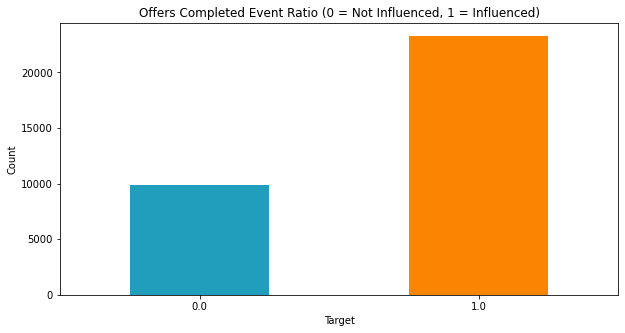

In [43]:
fig, ax = plt.subplots(figsize=(10,5))

# event ratio
final_data.target.value_counts().sort_index().plot(kind='bar', color=['#219ebc', '#fb8500'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Offers Completed Event Ratio (0 = Not Influenced, 1 = Influenced)')
ax.set_xlabel('Target')
ax.set_ylabel('Count');

### Normalise Numeric Attributes

In [44]:
# convert floats to ints
change_dtype_cols = ['offer_bogo', 'offer_discount', 'offer_informational',
                     'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'target']

for col in change_dtype_cols:
    final_data[col] = final_data[col].astype(int)
    
# normalise some numeric attributes
scaler = MinMaxScaler()
features_to_scale = ['time_hours', 'tenure_in_months', 'reward', 'difficulty', 'duration_hours']
final_data[features_to_scale] = scaler.fit_transform(final_data[features_to_scale])

In [45]:
# Drop columns which have only 1 unique value and don't add anything to the dataset
final_data.drop(['channel_email', 'offer_informational'], axis=1, inplace=True)

## Correlation Matrix

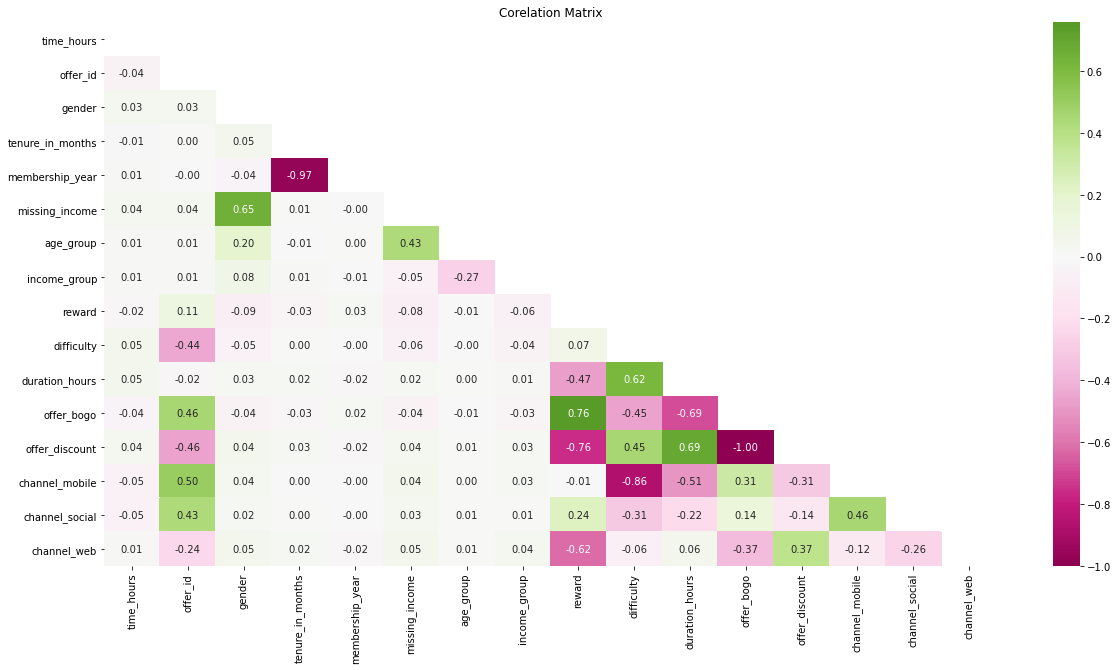

In [46]:
plt.figure(figsize = [20,10])

#correlation matrix
corr = final_data.loc[:, final_data.columns != 'target'].corr()
#only plot half
matrix = np.triu(corr)

sns.heatmap(corr, mask=matrix, annot = True, fmt = '.2f', cmap = 'PiYG', center = 0)
plt.title('Corelation Matrix');

In [47]:
# reset and check index
final_data.reset_index(inplace=True, drop=True)
final_data.index

RangeIndex(start=0, stop=33182, step=1)

In [48]:
# Check shape, dtypes and sample of final dataset
print_line('Shape')
print(final_data.shape)
print_line('Dtypes')
print(final_data.dtypes)
final_data.head()

**************************************************
		Shape
**************************************************
(33182, 17)
**************************************************
		Dtypes
**************************************************
time_hours          float64
offer_id              int32
gender                int32
tenure_in_months    float64
membership_year       int32
missing_income        int32
age_group             int32
income_group          int32
reward              float64
difficulty          float64
duration_hours      float64
offer_bogo            int32
offer_discount        int32
channel_mobile        int32
channel_social        int32
channel_web           int32
target                int32
dtype: object


,time_hours,offer_id,gender,tenure_in_months,membership_year,missing_income,age_group,income_group,reward,difficulty,duration_hours,offer_bogo,offer_discount,channel_mobile,channel_social,channel_web,target
0,0.806723,2,1,0.25,4,0,1,1,0.000,0.333333,0.4,0,1,1,0,1,0
1,0.579832,8,1,0.25,4,0,1,1,0.375,0.000000,0.0,1,0,1,1,1,0
2,0.739496,9,1,0.25,4,0,1,1,0.000,0.333333,1.0,0,1,1,1,1,0
3,0.806723,0,2,0.10,5,0,2,2,0.375,1.000000,1.0,0,1,0,0,1,1
4,0.352941,1,2,0.10,5,0,2,2,0.125,0.133333,0.4,0,1,1,1,1,1


---
<a id='section4'><h1> 4. Modelling</h1></a>

---

The following are the attributes which will be used for the model:

In [49]:
# all columns except target variable
final_data.loc[:, final_data.columns != 'target'].columns

Index(['time_hours', 'offer_id', 'gender', 'tenure_in_months',
       'membership_year', 'missing_income', 'age_group', 'income_group',
       'reward', 'difficulty', 'duration_hours', 'offer_bogo',
       'offer_discount', 'channel_mobile', 'channel_social', 'channel_web'],
      dtype='object')

In [50]:
# split data into features and target
X = final_data.copy()
y = X['target']
X.pop('target')

print(X.columns)
print(X.shape)
print(y.shape)

Index(['time_hours', 'offer_id', 'gender', 'tenure_in_months',
       'membership_year', 'missing_income', 'age_group', 'income_group',
       'reward', 'difficulty', 'duration_hours', 'offer_bogo',
       'offer_discount', 'channel_mobile', 'channel_social', 'channel_web'],
      dtype='object')
(33182, 16)
(33182,)


In [51]:
X.head()

,time_hours,offer_id,gender,tenure_in_months,membership_year,missing_income,age_group,income_group,reward,difficulty,duration_hours,offer_bogo,offer_discount,channel_mobile,channel_social,channel_web
0,0.806723,2,1,0.25,4,0,1,1,0.000,0.333333,0.4,0,1,1,0,1
1,0.579832,8,1,0.25,4,0,1,1,0.375,0.000000,0.0,1,0,1,1,1
2,0.739496,9,1,0.25,4,0,1,1,0.000,0.333333,1.0,0,1,1,1,1
3,0.806723,0,2,0.10,5,0,2,2,0.375,1.000000,1.0,0,1,0,0,1
4,0.352941,1,2,0.10,5,0,2,2,0.125,0.133333,0.4,0,1,1,1,1


In [52]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## Basic Models

### Instantiate model objects

In the following cell, a number of different model objects are instantiated. We will check their basic performance and compare metrics. We will then run a GridSearchCV using these models with many more hyperparameters.

In [53]:
## Random Forest
# Model Object
rdf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)

## LGR
# Model Object
lgr = LogisticRegression(random_state=RANDOM_STATE, solver="saga")

## Light Gradient Boosting Machine
# Model Object
gbm = lgbm.LGBMClassifier(random_state=RANDOM_STATE)

## SVC
# Model Object
lsvc = LinearSVC(random_state=RANDOM_STATE)

## SGD Classifier
# Model Object
sgdc = SGDClassifier(random_state=RANDOM_STATE)

In [54]:
model_list = [lgr, rdf, gbm, lsvc, sgdc]

for model in model_list:
    # fit model
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    # print evaluation metrics
    print_line("Model:")
    print(model)
    print_line("Confusion Matrix:")
    print(confusion_matrix(y_pred, y_test))
    print_line("Classification Report:")
    print(classification_report(y_pred, y_test))

C:\Users\SNicConmara\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


**************************************************
		Model:
**************************************************
LogisticRegression(random_state=42, solver='saga')
**************************************************
		Confusion Matrix:
**************************************************
[[1049  795]
 [1498 4954]]
**************************************************
		Classification Report:
**************************************************
              precision    recall  f1-score   support

           0       0.41      0.57      0.48      1844
           1       0.86      0.77      0.81      6452

    accuracy                           0.72      8296
   macro avg       0.64      0.67      0.64      8296
weighted avg       0.76      0.72      0.74      8296

**************************************************
		Model:
**************************************************
RandomForestClassifier(n_estimators=500, random_state=42)
**************************************************
		Confusion Mat

C:\Users\SNicConmara\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


**************************************************
		Model:
**************************************************
LinearSVC(random_state=42)
**************************************************
		Confusion Matrix:
**************************************************
[[1033  775]
 [1514 4974]]
**************************************************
		Classification Report:
**************************************************
              precision    recall  f1-score   support

           0       0.41      0.57      0.47      1808
           1       0.87      0.77      0.81      6488

    accuracy                           0.72      8296
   macro avg       0.64      0.67      0.64      8296
weighted avg       0.77      0.72      0.74      8296

**************************************************
		Model:
**************************************************
SGDClassifier(random_state=42)
**************************************************
		Confusion Matrix:
**********************************************

## More Complex Models

### GridSearchCV

**Note:** LightGBM was the best model. To save time, the grid search can be run using only the light GBM grid if desired (please see line 69/70 in the cell below).

In [55]:
## LGR

# Model Object
lgr = LogisticRegression(class_weight="balanced", 
                         random_state=RANDOM_STATE, 
                         solver="saga", 
                         C=1, 
                         warm_start=False,
                         max_iter=500, 
                         penalty="elasticnet",
                         l1_ratio=1)
# LGR Parameters
p_grid_lgr = {'model': [lgr],
              'model__C': np.logspace(-3, 3, 7),
              'model__l1_ratio': [0, 0.4, 0.6, 0.8, 1]}

## Random Forest

# Model Object
rdf = RandomForestClassifier(class_weight="balanced", 
                             random_state=48, 
                             n_estimators=100, 
                             oob_score=False, 
                             max_depth=None)
# RDF Parameters
p_grid_rdf = {'model': [rdf],
              'model__n_estimators': [80, 90, 100, 150, 200],
              'model__min_samples_leaf': [3, 5, 10, 20, 35, 50],
              'model__max_features': ["sqrt", "log2"]}

## Light Gradient Boosting Machine

# Model Object
gbm = lgbm.LGBMClassifier(class_weight="balanced", 
                          random_state=RANDOM_STATE, 
                          boosting_type="gbdt", 
                          tree_learner="serial", 
                          objective="binary")
# LGBM Parameters
p_grid_gbm = {'model': [gbm],
              'model__n_estimators': [90, 100, 200],
              'model__max_depth': [3, 12, 63, -1],
              'model__num_leaves': [8, 35, 143, 3968],
              'model__feature_fraction': [0.7, 0.8, 0.9, 1]}
## SVC

# Model Object
lsvc = LinearSVC(class_weight='balanced',
                 penalty='l2',
                 dual=False,  # Prefer dual=False when n_samples > n_features.
                 random_state=RANDOM_STATE)
# SVC Parameters
p_grid_lsvc = {'model': [lsvc],
               'model__C': np.logspace(-3, 3, 7)}

## SGD Classifier

# Model Object
sgdc = SGDClassifier(random_state=RANDOM_STATE, 
                     loss='log',
                     penalty='elasticnet',
                     class_weight='balanced')
# SGD Parameters
p_grid_sgdc = {'model': [sgdc],
               'model__alpha': np.logspace(-6, 2, 10),
               'model__l1_ratio': np.linspace(0, 1, 10)}

# Parameters
p_grid = [p_grid_gbm, p_grid_lsvc, p_grid_rdf, p_grid_sgdc, p_grid_lgr]
#p_grid = [p_grid_gbm] # use this p_grid to avoid running entire grid search

In [56]:
## Model Training Pipeline

# Cross Validation Folds

# Stratified CV Count
cv = StratifiedKFold(n_splits=3)

# SMOTE - Artificial Data to better balance the unbalanced events
smote = SMOTE(random_state=RANDOM_STATE)

# Pipeline Steps
steps = [('SMOTE', smote),
         ('model', None)]

# Grid
model_pipe = imb_pipeline(steps)

grid = GridSearchCV(model_pipe,
                   param_grid=p_grid,
                   cv=cv,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=2)

Below cell with 1182 fits takes **~8mins** to run if you run the full GridSearchCV

In [57]:
%%time
# Model Training

# Grid Fit/Score
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

# Model Extraction
model = grid.best_estimator_['model']

Fitting 3 folds for each of 394 candidates, totalling 1182 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1182 out of 1182 | elapsed:  8.0min finished


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Wall time: 8min


**LGBMClassifier is the best estimator, producing an accuracy score of 0.74**

In [58]:
model

LGBMClassifier(class_weight='balanced', feature_fraction=0.7, max_depth=63,
               n_estimators=200, num_leaves=35, objective='binary',
               random_state=42, tree_learner='serial')

---
<a id='section5'><h1> 5. Model Evaluation</h1></a>

---

### Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           0       0.58      0.50      0.54      2547
           1       0.79      0.84      0.82      5749

    accuracy                           0.74      8296
   macro avg       0.69      0.67      0.68      8296
weighted avg       0.73      0.74      0.73      8296



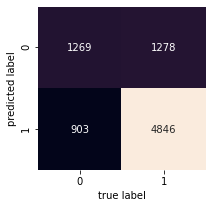

In [59]:
### Model Evaluation

## Model Prediction
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

plot_conf_mat(y_test, y_pred)

### Feature Importances

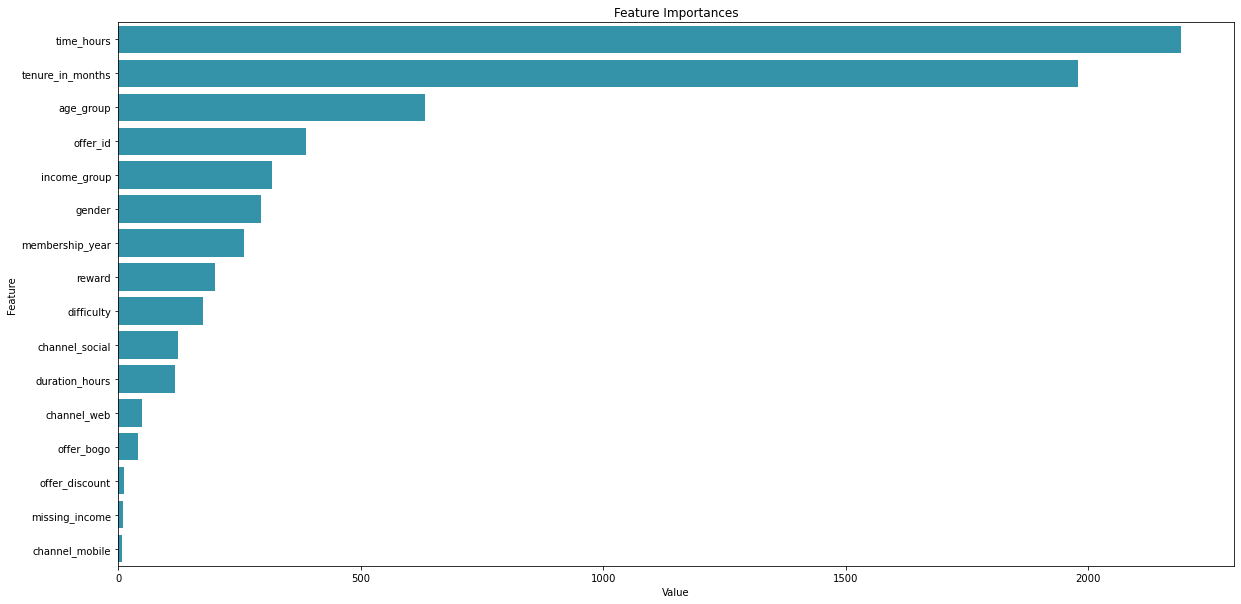

In [60]:
feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False), color='#219ebc')
plt.title('Feature Importances')
plt.show()

The 3 most important features in this model were the **time in hours since the start of the test**, the **customer's tenure in months** and the **age group** of the customer.

In [61]:
model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(class_weight='balanced', feature_fraction=0.7, max_depth=63,
               n_estimators=200, num_leaves=35, objective='binary',
               random_state=42, tree_learner='serial')>

### Improving upon the algorithms and techniques used

#### Initial Solution

The intitial baseline models all produced acuuracy scores between 0.72 and 0.74 with LightGBM producing the best accuracy. I had always intended to run a GridSearch and therefore kept the parameters very basic initially.

#### Final Solution
When running the full GridSearchCV with multiple hyperparamters, LightGBM was also the best model overall, producing an accuracy score of 0.74. "LightGBM is a gradient boosting framework that uses tree based learning algorithms" [(source)](https://lightgbm.readthedocs.io/en/latest/). LightGBM was likely the best model because it is better in terms of performance an speed and also it "produces more complex trees by following leaf-wise split approach rather than a level-wise approach" [(source)](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/#:~:text=Better%20accuracy%20than%20any%20other,by%20setting%20the%20max_depth%20parameter.) which allows for better accuracy. I initially experiemented with SMOTE 

#### Final Model Parameters
```LGBMClassifier(class_weight='balanced', feature_fraction=0.7, max_depth=63,n_estimators=200, num_leaves=35, objective='binary',random_state=42, tree_learner='serial')```

```class_weight='balanced'``` - modifies the loss function by giving more/less penalties to the classes with more (or less) weight

```feature_fraction=0.7``` - 70% of features are selected before training each tree

```max_depth=63``` - this is the maximum tree depth

```n_estimators=200``` - this is the number of boosted trees to fit

``` num_leaves=35``` - this is the maximum number of tree leaves for base learners

```objective='binary'```- this specifies the learning task

```random_state=42``` - this is the random number seed

```tree_learner='serial'``` - this is the default tree_learner (single machine tree learner)

[source 1](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

[source 2](https://datascience.stackexchange.com/questions/52627/why-class-weight-is-outperforming-oversampling)
               
#### Improvements
To improve on the current model's performance, we could use a GPU-enabled version of LightGBM to train a model faster [(source)](https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html). Early stopping could also be experimented with. Early stopping means that "after each boosting round the model’s training accuracy is evaluated against a validation set that contains data not available to the training process. That accuracy is then compared to the accuracy as of the previous boosting round. If the model’s accuracy fails to improve for some number of consecutive rounds, LightGBM stops the training process" [(source)](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#use-early-stopping).

---
<a id='section6'><h1> 6. Conclusion</h1></a>

---

### Conclusion

In conclusion, this project **successfully answered the questions I set out to answer via exploratory data analysis and also produced a relatively accuracte supervised machine learning model** to idneitfy customers who would complete an offer without influence and those who would complete an offer as a direct result of viewing the offer in the app beforehand. 

The questions posed and answered above:

**Q1.** What was the age distribution of Starbucks customers in the dataset?

**Q2.** What was the distribution of customer tenure in the dataset?

**Q3.** What year saw the most new memberships and what month of the year saw the most memberships?

**Q4.** What was the gender distribution of customers in the Starbucks dataset? 

**Q5.** What was the income distribution by gender?

**Q6.** What was the income distribution by age group?

**Q7.** What was the distribution of events in the transcript dataset?

**Q8.** Was there a pattern in the release of offers?

**Q9.** What was the distribution of transaction amounts?

**Q10.** What were the most common offer types by channel?

**Q11.** What were the distributions for duration, reward and difficulty of offers?

**Q12.** What was the mean spend and number of transactions by gender?

**Q13.** What offer types were most popular across age groups and income groups?

**Q14.** What offer types were most popular across genders and membership years?

**The final accuracy of the LightGBM model was 0.74.**

For a company like Starbucks, this type of a model would be useful in creating **targeted marketing** towards customers likely to be influenced to complete offers rather than simply targeting the entire customer base or those who would complete the offer regardless. This would save Starbucks money if for example they used SMS campaigns or postal campaigns for example. They could also **avoid sending offers to customers who would complete the offer regardless in order to increase profits.**

#### Personal Insights

An aspect I found slightly difficult was the target variable creation.
The challenges surrounding the target variable creation were as follows:
- not all users receive the same offer
- a user can receive an offer, never view the offer but still 'complete' the offer according to the data
- a user can also 'complete' an offer without having received nor viewed it according to the data

I solved this by applying the following logic:

- a customer was given a **target value of 1 (event)** if they had **completed the offer after having viewed the offer.** It is assumed that a customer would have had to receive the offer in order for it to be possible for them to view it in the app. 

- If a customer **completed the offer without viewing, viewed the offer after completing it or completed the offer without receiving or viewing it,** they were assigned a **target value of 0 (non-event).**

Interestingly, I learned several unexpected things from exploring the Starbucks dataset such as:

- below average and average income customers had nearly the same amount of transactions compared to those with above average income. Customers with average income completed the most offers, followed by those with below average income and those with above average income.

- when looking at income distribution by gender, the average income of Starbucks customers is higher for females than for males. The distribution of female incomes is also wider and less-skewed than the male income distribution. However, both male and female incomes range from 30k to 120k.

Overall, the experience gained from data wrangling, data exploration, 
data visualisation, feature engineering, data encoding, data scaling, model development and model evaluation has undoubtedly benefitted me and helped me to improve my skills as an aspiring data scientist.